# Using Fastai Tabular For Tabular Playground Series June 2021 Competition
> Here I use fastai with some changes to the defaults to make a submission to Kaggle for the Tabular Playground Series June 2021 competition.

- toc: true 
- badges: true
- comments: true
- categories: [kaggle, fastai]
- author: Nissan Dookeran
- image: images/chart-preview.png

## Introduction

This is a modification of the ["first pass" submission](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/25/_First_Pass_Using_Fastai_For_Homesite_Competition.html) to the Homesite Competition on Kaggle Competition using Google Colab, but modifying some of the default parameters and maybe adding some learning from the [initial exploratory data analysis](https://redditech.github.io/team-fast-tabulous/kaggle/2021/06/23/Exploring-Homesite_Data.html) on other projects to apply to this one, to see if I can applying what was learnt so far to see how it fairs in a submission.

Changes made:
- Use TestTrainSplitter() for making test and validation sets more fairly weighted based on the bias of any input data towards negative results
- Increase batch size to 1024 to make training shorter, but to still hopefully get a better predictor for it. Set a separate validator batch size to 128.
- Increase the validation percentage to 0.25
- Fix the learning rate to 1e-3
- Increase epochs to 5
- Modified the `cat_names` and `cont_names` arrays with any initial EDA insights
- Add a date part for dates
- Add weight decay of 0.2

## Setup fastai and Google drive

In [1]:
!pip install -Uqq fastai


In [2]:
from fastai.tabular.all import *

In [3]:
!pip install kaggle

Useful links here:
- Documentation on [Path library](https://docs.python.org/3/library/pathlib.html#basic-use)
- Documentation on [fastai extensions to Path library](https://fastcore.fast.ai/xtras.html#Extensions-to-Pathlib.Path)

In [4]:
Path.cwd()

Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks')

## Environment Setup
> Setup the environment variables here (these will change as we play around to get the best model for submission)
- Set the random seed so that the results are reproducible
- Set the batch size for training
- Set the batch size for validation
- Set what portion of training data to set aside for validation
- Set the number of epochs of training to run to not overfit
- Set the learning rate to be used
- Set the weight decay

In [5]:
set_seed(42) 
bs = 1024
val_bs = 128
test_size = 0.25
epochs = 5
lr = 1e-3
wd=0.2

## Setup kaggle environment parameters

In [6]:
from kaggle import api

In [7]:
path = Path.cwd()
path.ls()

(#10) [Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/.gitignore'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/.ipynb_checkpoints'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/2021-06-21-Getting-Data-In-Kaggle.ipynb'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/2021-06-27-Using-Fastai-For-tabular-playground-series-jun-2021.ipynb'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/2021_06_23_Messing_around_with_fastai.ipynb'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/ghtop_images'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/my_icons'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/README.md'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/Untitled.ipynb'),Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/_data')]

> This bit is to make sure I don't checkin my data to Github when I'm finished

In [8]:
!touch .gitignore

In [9]:
!echo "_data" > .gitignore

In [10]:
!head .gitignore

_data


In [11]:
!mkdir _data

mkdir: cannot create directory ‘_data’: File exists


In [12]:
os.chdir('_data')
Path.cwd()

Path('/mnt/d/Code/GitHub/reddi-hacking/_notebooks/_data')

In [13]:
path = Path.cwd()/"playground_Jun_2021_data"
path.mkdir(exist_ok=True)
Path.BASE_PATH = path
api.competition_download_cli('tabular-playground-series-jun-2021', path=path)


tabular-playground-series-jun-2021.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
path.ls()

(#5) [Path('sample_submission.csv'),Path('submission8.csv'),Path('tabular-playground-series-jun-2021.zip'),Path('test.csv'),Path('train.csv')]

In [15]:
file_extract(path/"tabular-playground-series-jun-2021.zip")

In [16]:
path.ls()

(#5) [Path('sample_submission.csv'),Path('submission8.csv'),Path('tabular-playground-series-jun-2021.zip'),Path('test.csv'),Path('train.csv')]

## Exploring the Playground data

In [17]:
df_train = pd.read_csv(path/"train.csv", low_memory=False)
df_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,...,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,...,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,...,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2


In [18]:
df_train.shape

(200000, 77)

In [19]:
df_train.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000
mean,99999.500000,0.972710,1.168365,2.219325,2.296735,0.793530,1.431105,1.010695,0.673090,1.94398,...,1.798040,0.508695,1.827300,0.910370,1.603585,1.219210,0.806895,1.282925,2.94021,0.632005
std,57735.171256,3.941836,3.993407,6.476570,7.551858,2.935785,5.162746,3.949231,2.234949,3.93133,...,5.053014,1.867330,7.188924,3.835182,4.877679,4.826003,2.458741,4.261420,10.78465,3.925310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,49999.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,99999.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,149999.250000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.00000,...,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.00000,0.000000
max,199999.000000,61.000000,51.000000,64.000000,70.000000,38.000000,76.000000,43.000000,30.000000,38.00000,...,54.000000,24.000000,79.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.00000,52.000000


In [20]:
True in df_train.isna()


False

In [21]:
df_test = pd.read_csv(path/"test.csv", low_memory=False)
df_test.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,200000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,200001,1,2,0,0,0,0,0,0,0,...,3,1,3,0,0,0,0,3,0,0
2,200002,0,1,7,1,0,0,0,0,6,...,3,0,0,0,0,3,0,2,0,0
3,200003,0,0,0,4,3,1,0,0,0,...,0,0,0,1,0,0,0,4,0,0
4,200004,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
df_test.shape

(100000, 76)

In [23]:
True in df_test.isna()

False

In [24]:
y_column = df_train.columns.difference(df_test.columns)

In [25]:
y_column

Index(['target'], dtype='object')

From this it looks like `target` is the value we want to predict. Let's take a look at this

In [26]:
type(df_train.target)

pandas.core.series.Series

In [27]:
df_train.target.unique()

array(['Class_6', 'Class_2', 'Class_8', 'Class_3', 'Class_1', 'Class_5',
       'Class_7', 'Class_9', 'Class_4'], dtype=object)

In [28]:
type(df_train.target.unique()[0])

str

In [29]:
df_train.target.isna().sum()

0

#### Set the y column type

Make this a category for the purpose of generating predictions as a classification

In [30]:
df_train.target = df_train.target.astype(dtype='category')

In [31]:
target_categories = df_train['target'].unique()
target_categories

['Class_6', 'Class_2', 'Class_8', 'Class_3', 'Class_1', 'Class_5', 'Class_7', 'Class_9', 'Class_4']
Categories (9, object): ['Class_6', 'Class_2', 'Class_8', 'Class_3', ..., 'Class_5', 'Class_7', 'Class_9', 'Class_4']

In [32]:
df_train['target'].cat.set_categories(target_categories, inplace=True)

Let's see how the training data outcomes are balanced

In [33]:
df_train.target.describe()

count      200000
unique          9
top       Class_6
freq        51811
Name: target, dtype: object

In [34]:
train_data_balance = pd.DataFrame(df_train["target"]).groupby("target")

In [35]:
train_data_balance["target"].describe()

,count,unique,top,freq
target,,,,
Class_6,51811,1,Class_6,51811
Class_2,24431,1,Class_2,24431
Class_8,51763,1,Class_8,51763
Class_3,14798,1,Class_3,14798
Class_1,9118,1,Class_1,9118
Class_5,3064,1,Class_5,3064
Class_7,14769,1,Class_7,14769
Class_9,25542,1,Class_9,25542
Class_4,4704,1,Class_4,4704


It's not quite equally weighted, e.g. `Class_4` and `Class_5` are ten times less than `Class_6`

## First things first 
- `id` looks unique so we can test this and if true, make it the index

Additionally, we should make sure to apply any changes to data types to both train and test data so predictions don't fail later on


In [36]:
df_train.id.value_counts(), df_test.id.value_counts()

(0         1
 111331    1
 49869     1
 56014     1
 53967     1
          ..
 183667    1
 193908    1
 195957    1
 189814    1
 2047      1
 Name: id, Length: 200000, dtype: int64,
 262144    1
 269609    1
 206158    1
 212301    1
 210252    1
          ..
 283295    1
 285342    1
 279197    1
 281244    1
 264191    1
 Name: id, Length: 100000, dtype: int64)

In [37]:
df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

## Goal: Better model training, refining fastai parameters, using EDA insights gathered to date

In [38]:
y_names = [y_column[0]]
y_names

['target']

In [39]:
cont_names, cat_names = cont_cat_split(df_train, dep_var=y_names)
len(cont_names), len(cat_names)

(72, 3)

## EDA on the categorical and continuous feature splits 
> Functions to improve fastai's `cont_cat_split` choices

The goal here is to validate the splot, rearrange as needed, and explicitly set the dtype and categories for categorical columns. I am going to use what I wrote for [another post](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/27/Improving-Fastai-split-choices.html#New-Work---A-function-to-improve-fastai's-cont_cat_split-choices) with some functions that help speed up evaluating the splits and reassigning them better than the fastai defaults

First I'll create a `triage` list for any fields that can't be programmatically optimized. These are the ones we have to do manual steps for until I find a way to do better

In [40]:
triage = L()

Let's take a quick look at the descriptions of the categorical and continuous splits automatically done

In [41]:
df_train[cont_names].astype('object').describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
count,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,...,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000
unique,42,37,48,59,30,55,40,26,28,51,...,41,23,57,42,52,49,31,37,91,50
top,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,146389,140375,122501,120767,154093,119020,150969,150350,117000,124466,...,124517,165048,141642,145532,113213,132247,139966,123153,142555,169451


The first thing I notice, is that for a number of these fields, there is quite a low number of `unique` values. Luckily, I don't see any missing or NA values as all the `count` totals are equal to the total number of rows of data. These are a lot of fields to go through and manually recategorize and then get their categories, but I am hoping I can do this programmatically.

Let's have a look at the existing categoricals to make sure there's nothing suspeicious about these here either

In [42]:
df_train[cat_names].astype('object').describe()

,feature_17,feature_26,feature_30
count,200000,200000,200000
unique,15,20,18
top,0,0,0
freq,169538,127772,134843


Here I define two functions, which will help 
- to reset the `cont_names` and `cat_names` arrays with better fits of the actual data fields for those that are categorical, but were put into the continuous array. 
- For all cateogorical fields, it will also setup the categories for these fields and change their dtype 
- For any fields that have null values, it will remove them from their respective field, and place them in the `triage` list

In [43]:
def reassign_to_categorical(field, df, continuous, categorical, triage):
  if df[field].isna().sum()==0:
    field_categories = df[field].unique()
    df[field] = df[field].astype('category')
    df[field].cat.set_categories(field_categories, inplace=True)
    if field in continuous: continuous.remove(field)
    if field not in categorical: categorical.append(field)
  else:
    if field in continuous: continuous.remove(field)
    if field in categorical: categorical.remove(field)
    triage.append(field)

  return df, continuous, categorical, triage

In [44]:
def categorize( df, cont_names, cat_names, triage, category_threshold):
  for field in df.columns:
    if ((len(df[field].unique()) <= category_threshold) and (type(df[field].dtype) != pd.core.dtypes.dtypes.CategoricalDtype)):
      reassign_to_categorical(field, df, cont_names, cat_names, triage)
  return df, cont_names, cat_names, triage

In [45]:
df_train, cont_names, cat_names, triage = categorize(df_train, cont_names, cat_names, triage, 100)

In [46]:
len(cont_names), len(cat_names)

(1, 74)

So this is a big rebalancing between continuous and categorical fields. I saved alot of time with this function rather than doing this manually like I had for my initial data exploration. Let's take a look at how many came up for triaging still though

In [47]:
triage

(#0) []

This was expected, since my triage fields would only be those that have NA values,so that we can look closer at the data to evaluate a FillMissing strategy, or if we have too many missing data values, to ignore the field in modelling

#### Prep the learner

> Check to make sure I didn't make any typos, if the counts show any missing rows that's a sign

In [48]:
df_train.describe(include='all')

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
count,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,...,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000
unique,42.0,37.0,48.0,59.0,30.0,55.0,40.0,26.0,28.0,51.0,...,23.0,57.0,42.0,52.0,49.0,31.0,37.0,91.0,50.0,9
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_6
freq,146389.0,140375.0,122501.0,120767.0,154093.0,119020.0,150969.0,150350.0,117000.0,124466.0,...,165048.0,141642.0,145532.0,113213.0,132247.0,139966.0,123153.0,142555.0,169451.0,51811
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
True in df_train.isna()

False

In [50]:
"id" in cont_names, "id" in cat_names #Make sure we've gotten our y-column excluded

(False, False)

In [51]:
procs = [Categorify, FillMissing, Normalize]
splits = TrainTestSplitter(test_size=test_size, stratify=df_train[y_names])(df_train)

In [116]:
to = TabularPandas(df=df_train, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=y_names,splits=splits)
dls = to.dataloaders(bs=bs, val_bs=val_bs, layers=[500,1000], ps=[0.01,0.001])
dls.valid.show_batch()


,feature_17,feature_26,feature_30,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_27,feature_28,feature_29,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_15,target
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,17,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.692236e-08,Class_2
1,0,1,1,1,0,0,0,0,2,0,0,1,1,0,0,0,0,3,0,4,3,0,0,0,0,1,1,0,0,1,2,1,2,0,0,0,0,0,0,0,3,0,2,0,0,0,1,3,0,1,2,0,0,1,0,0,0,0,1,2,0,6,0,0,0,1,5,0,0,0,0,4,0,1,4.692236e-08,Class_2
2,6,0,0,0,0,0,2,0,0,1,0,0,1,2,1,0,0,1,0,0,8,0,0,0,0,0,1,0,0,0,0,0,0,0,1,4,1,1,0,0,0,1,1,0,1,0,0,0,1,2,1,0,0,8,1,4,0,0,0,2,0,1,0,0,15,0,0,0,0,0,4,0,0,0,4.692236e-08,Class_6
3,0,0,0,0,3,0,1,3,0,0,0,9,1,0,32,1,1,0,1,5,0,0,0,0,0,0,8,0,2,0,3,1,0,0,0,0,5,0,0,1,0,0,9,2,0,0,0,4,0,2,0,0,2,14,0,0,0,2,5,1,1,0,0,0,5,0,0,1,0,0,0,1,0,0,4.692236e-08,Class_6
4,2,0,0,1,23,0,1,0,1,1,0,0,41,0,1,0,1,1,0,1,2,3,4,0,0,0,14,2,0,12,4,54,2,1,0,0,1,11,3,13,0,0,3,0,0,0,1,1,0,0,42,0,3,54,0,25,0,0,0,1,0,3,2,19,0,0,0,0,0,1,1,0,0,0,4.692236e-08,Class_2
5,0,0,0,0,0,0,0,0,0,2,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,4.692236e-08,Class_4
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7,0,1,0,2,1,0,10,0,0,0,0,0,0,0,2,0,10,0,1,0,1,2,0,0,0,1,3,1,0,0,0,0,0,1,1,0,2,6,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,1,0,4.692236e-08,Class_8
7,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,3,0,0,0,1,3,0,0,1,0,0,0,0,0,0,1,1,8,0,1,0,3,0,2,0,0,0,6,0,0,0,0,0,0,4,0,0,4,4,0,0,0,0,0,1,0,4,0,0,7,0,0,1,4,0,0,0,0,0,4.692236e-08,Class_8
8,0,0,0,6,1,0,1,1,2,0,5,1,0,0,0,2,0,3,2,6,0,5,0,0,1,2,3,1,1,0,0,0,0,1,2,2,2,6,4,1,3,0,3,4,1,7,0,1,0,2,1,0,4,18,0,2,0,1,1,1,0,4,1,0,7,0,0,0,0,1,0,2,6,0,2.000000e+00,Class_6
9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.692236e-08,Class_9


In [117]:
len(dls.train)*bs, len(dls.valid)*val_bs

(149504, 50048)

In [118]:

learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=tensor(0.0014))

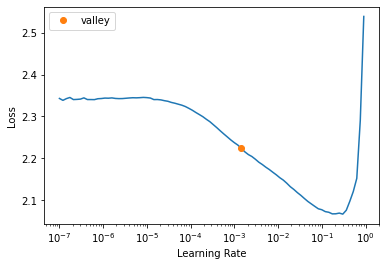

In [119]:
learn.lr_find()

[Reference to why we use fit_one_cycle](https://fastai1.fast.ai/callbacks.one_cycle.html)

In [120]:
lr = 0.0014
epochs = 4

In [121]:
learn.fit_one_cycle(epochs,lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,1.896143,1.822293,0.354460,00:08
1,1.757242,1.751968,0.357080,00:07
2,1.730326,1.753791,0.358260,00:07
3,1.686104,1.768173,0.353260,00:08


In [122]:
preds, targs = learn.get_preds()


In [123]:
preds.shape

torch.Size([50000, 9])

In [124]:
preds[0:1]

tensor([[0.2783, 0.1893, 0.1261, 0.1215, 0.0377, 0.0127, 0.0480, 0.1469, 0.0395]])

In [125]:
len(preds)

50000

Doing inferences based on this [blog post](https://walkwithfastai.com/tab.clas.binary) from Walk With Fastai initially, but then experimenting to get this

In [126]:
dl_test = dls.test_dl(df_test)

In [127]:
preds, _ = learn.get_preds(dl=dl_test)

In [128]:
preds.shape

torch.Size([100000, 9])

## Submission To Kaggle

In [129]:
path.ls()

(#6) [Path('sample_submission.csv'),Path('submission8.csv'),Path('submission9.csv'),Path('tabular-playground-series-jun-2021.zip'),Path('test.csv'),Path('train.csv')]

In [130]:
df_submission = pd.read_csv(path/"sample_submission.csv") #I could add `low_memory=false` but it makes things slower
df_submission.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
1,200001,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
2,200002,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
3,200003,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
4,200004,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111


In [131]:
df_submission.tail()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
99995,299995,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99996,299996,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99997,299997,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99998,299998,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
99999,299999,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111


In [132]:
len(df_test.index), len(preds)

(100000, 100000)

In [133]:
type(preds)

torch.Tensor

In [134]:
preds.dtype

torch.float32

In [135]:
preds_for_submission = preds.tolist() 
preds_for_submission[0:1]

[[0.14556929469108582,
  0.38398420810699463,
  0.0492408387362957,
  0.17785416543483734,
  0.05465058609843254,
  0.019792871549725533,
  0.024652695283293724,
  0.11572658270597458,
  0.028528723865747452]]

In [136]:
submission = pd.DataFrame({'id': df_test.index, 'Predictions': preds.tolist()}, columns=['id', 'Predictions'])

Needed to figure out how to extract the floating point value alone from the list to properly compose the csv output dataframe

In [137]:
type(submission.Predictions)

pandas.core.series.Series

In [138]:
type(submission.Predictions[0][0])

float

In [139]:
submission.Predictions[0][0]

0.14556929469108582

In [140]:
submission.Predictions.tolist()[0]

[0.14556929469108582,
 0.38398420810699463,
 0.0492408387362957,
 0.17785416543483734,
 0.05465058609843254,
 0.019792871549725533,
 0.024652695283293724,
 0.11572658270597458,
 0.028528723865747452]

In [141]:
submission.head()

,id,Predictions
0,200000,"[0.14556929469108582, 0.38398420810699463, 0.0492408387362957, 0.17785416543483734, 0.05465058609843254, 0.019792871549725533, 0.024652695283293724, 0.11572658270597458, 0.028528723865747452]"
1,200001,"[0.30568018555641174, 0.06748361885547638, 0.2821882963180542, 0.069472536444664, 0.05176167190074921, 0.011320285499095917, 0.08354373276233673, 0.10796741396188736, 0.020582210272550583]"
2,200002,"[0.7500181794166565, 0.026834947988390923, 0.08841108530759811, 0.02269136719405651, 0.009151597507297993, 0.007910830900073051, 0.026987241581082344, 0.05289360508322716, 0.015101218596100807]"
3,200003,"[0.2330009788274765, 0.10760820657014847, 0.23307044804096222, 0.07857377827167511, 0.05705545097589493, 0.02363131381571293, 0.06864532828330994, 0.1658260077238083, 0.03258843347430229]"
4,200004,"[0.3362259268760681, 0.10346393287181854, 0.2263432741165161, 0.08009770512580872, 0.04384588450193405, 0.009048418141901493, 0.0585983507335186, 0.11896053701639175, 0.02341604232788086]"


In [142]:
submission.index

RangeIndex(start=0, stop=100000, step=1)

In [143]:
submission[['Class_1','Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']] = pd.DataFrame(submission.Predictions.tolist(), index= submission.index)

In [144]:
submission.head()

,id,Predictions,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,"[0.14556929469108582, 0.38398420810699463, 0.0492408387362957, 0.17785416543483734, 0.05465058609843254, 0.019792871549725533, 0.024652695283293724, 0.11572658270597458, 0.028528723865747452]",0.145569,0.383984,0.049241,0.177854,0.054651,0.019793,0.024653,0.115727,0.028529
1,200001,"[0.30568018555641174, 0.06748361885547638, 0.2821882963180542, 0.069472536444664, 0.05176167190074921, 0.011320285499095917, 0.08354373276233673, 0.10796741396188736, 0.020582210272550583]",0.305680,0.067484,0.282188,0.069473,0.051762,0.011320,0.083544,0.107967,0.020582
2,200002,"[0.7500181794166565, 0.026834947988390923, 0.08841108530759811, 0.02269136719405651, 0.009151597507297993, 0.007910830900073051, 0.026987241581082344, 0.05289360508322716, 0.015101218596100807]",0.750018,0.026835,0.088411,0.022691,0.009152,0.007911,0.026987,0.052894,0.015101
3,200003,"[0.2330009788274765, 0.10760820657014847, 0.23307044804096222, 0.07857377827167511, 0.05705545097589493, 0.02363131381571293, 0.06864532828330994, 0.1658260077238083, 0.03258843347430229]",0.233001,0.107608,0.233070,0.078574,0.057055,0.023631,0.068645,0.165826,0.032588
4,200004,"[0.3362259268760681, 0.10346393287181854, 0.2263432741165161, 0.08009770512580872, 0.04384588450193405, 0.009048418141901493, 0.0585983507335186, 0.11896053701639175, 0.02341604232788086]",0.336226,0.103464,0.226343,0.080098,0.043846,0.009048,0.058598,0.118961,0.023416


In [145]:
submission.drop(["Predictions"],axis=1, inplace=True)

In [146]:
submission.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.145569,0.383984,0.049241,0.177854,0.054651,0.019793,0.024653,0.115727,0.028529
1,200001,0.305680,0.067484,0.282188,0.069473,0.051762,0.011320,0.083544,0.107967,0.020582
2,200002,0.750018,0.026835,0.088411,0.022691,0.009152,0.007911,0.026987,0.052894,0.015101
3,200003,0.233001,0.107608,0.233070,0.078574,0.057055,0.023631,0.068645,0.165826,0.032588
4,200004,0.336226,0.103464,0.226343,0.080098,0.043846,0.009048,0.058598,0.118961,0.023416


In [147]:
submission.to_csv(path/'submission10.csv', index=False)

In [148]:
api.competition_submit(path/'submission10.csv',message="Tenth pass", competition='tabular-playground-series-jun-2021')

100%|██████████| 17.9M/17.9M [00:10<00:00, 1.81MB/s]


Successfully submitted to Tabular Playground Series - Jun 2021

In [149]:
learn.save('tabular-playground-series-jun-2021_fastai_nn9')

Path('models/tabular-playground-series-jun-2021_fastai_nn9.pth')